# Types of features and image segmentation
---


Table of content

* [Harris corner detection](#section1)
* [Finding Contours](#section2)
* [K-means cluster for segmentation](#section3)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

<a id='section1'></a>
### Harris Corner Detection

For a further reading about Harris Corner Detection in OpenCV click [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html)


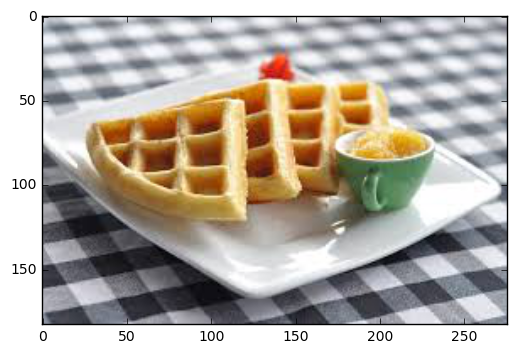

In [4]:
# Read in the image, make a copy of the image and change color to RGB (from BGR)
image = cv2.imread('data/waffle.jpg')
image_copy = np.copy(image)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

plt.imshow(image_copy)

#### Detect corners and dilate them

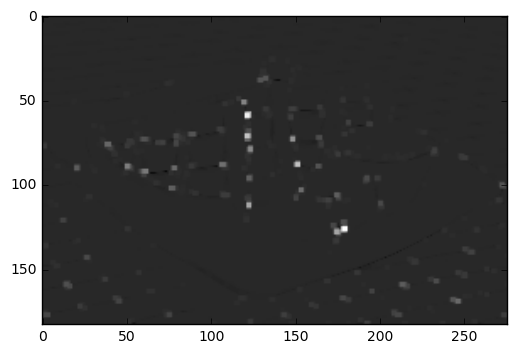

In [5]:
# Convert to grayscale
gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)

# Detect corners 
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# Dilate corner image to enhance corner points
dst = cv2.dilate(dst,None)

plt.imshow(dst, cmap='gray')

#### Extract and display strong corners

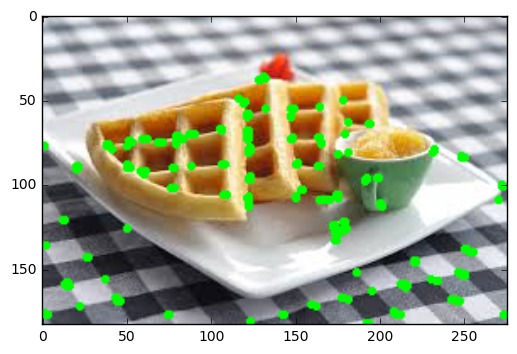

In [7]:
# This value vary depending on the image and how many corners you want to detect
# Try changing this free parameter, 0.1, to be larger or smaller ans see what happens
thresh = 0.05*dst.max()

# Create an image copy to draw corners on
corner_image = np.copy(image_copy)

# Iterate through all the corners and draw them on the image (if they pass the threshold)
for j in range(0, dst.shape[0]):
    for i in range(0, dst.shape[1]):
        if(dst[j,i] > thresh):
            # image, center pt, radius, color, thickness
            cv2.circle( corner_image, (i, j), 1, (0,255,0), 1)

plt.imshow(corner_image)

---

<a id='section2'></a>
### Finding Contours

#### Contour Features

Every contour has a number of features that you can calculate, including the area of the contour, it's orientation (the direction that most of the contour is pointing in), it's perimeter, and many other properties outlined in [OpenCV documentation, here](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html).

#### Orientation

The orientation of an object is the angle at which an object is directed. To find the angle of a contour, you should first find an ellipse that fits the contour and then extract the `angle` from that shape.

**Orientation values**

These orientation values are in degrees measured from the x-axis. A value of zero means a flat line, and a value of 90 means that a contour is pointing straight up!

So, the orientation angles that you calculated for each contour should be able to tell us something about the general position of the hand. The hand with it's thumb up, should have a higher (closer to 90 degrees) orientation than the hand with it's thumb down.


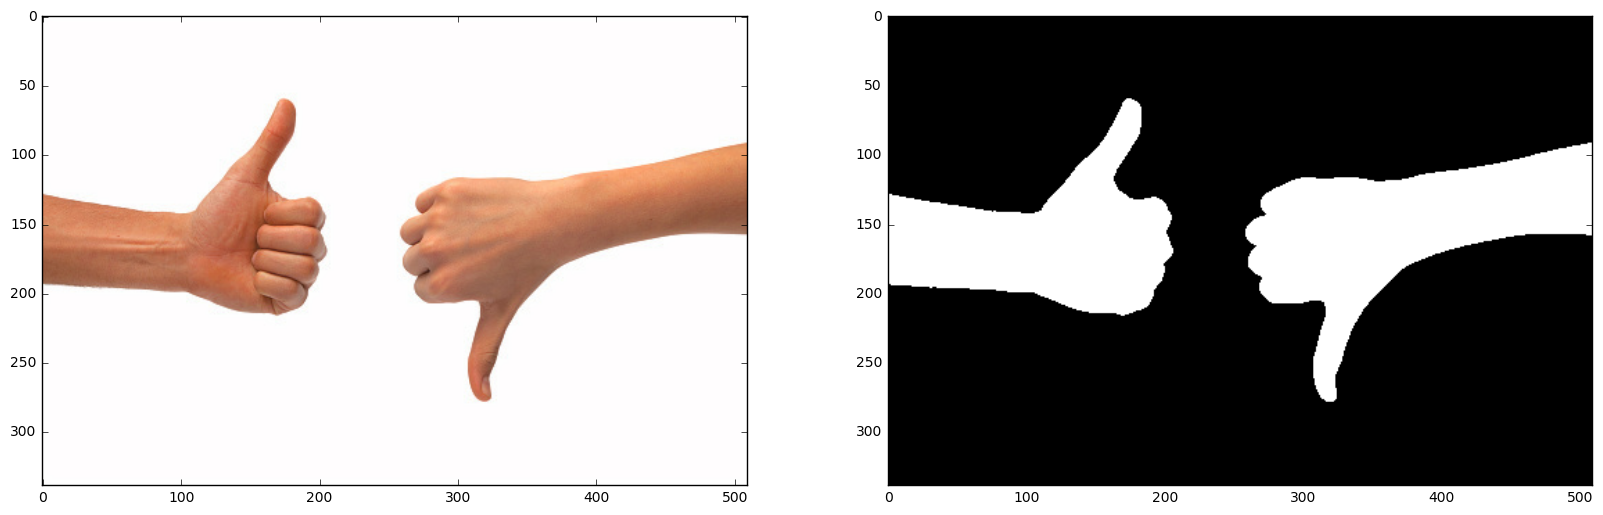

In [21]:
# Read in the image and change color to RGB (from BGR)
image = cv2.imread('data/thumbs_up_down.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale and create a binary thresholded image
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
retval, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)

# Display the images
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax2.imshow(binary, cmap='gray')

#### Find and draw the contours

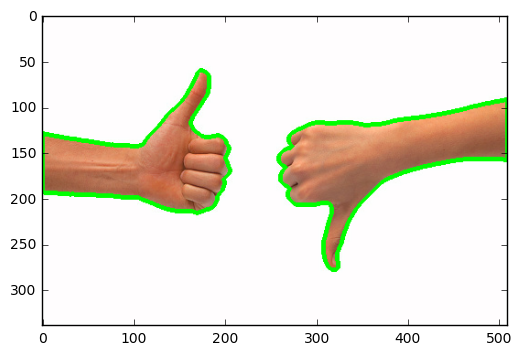

In [23]:
# Find contours from thresholded, binary image
retval, contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on a copy of the original image
contours_image = np.copy(image)
contours_image = cv2.drawContours(contours_image, contours, -1, (0,255,0), 3)

plt.imshow(contours_image)

In [25]:
## Returns the orientations of a list of contours
## The list should be in the same order as the contours
## i.e. the first angle should be the orientation of the first contour
def orientations(contours):
    """
    Orientation 
    :param contours: a list of contours
    :return: angles, the orientations of the contours
    """
    
    # Create an empty list to store the angles in
    # Tip: Use angles.append(value) to add values to this list
    angles = []
    for selected_contour in contours:
        (x,y), (MA,ma), angle = cv2.fitEllipse(selected_contour)
        angles.append(angle)
    
    return angles


# ---------------------------------------------------------- #
# Print out the orientation values
angles = orientations(contours)
print('Angles of each contour (in degrees): ' + str(angles))

Angles of each contour (in degrees): [61.35833740234375, 82.27550506591797]


#### Bounding Rectangle

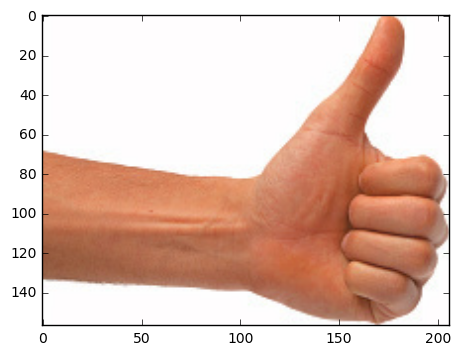

In [29]:
### TODO: Crop the image around a contour
def left_hand_crop(image, selected_contour):
    """
    Left hand crop 
    :param image: the original image
    :param selectec_contour: the contour that will be used for cropping
    :return: cropped_image, the cropped image around the left hand
    """
    
    ## Detect the bounding rectangle of the left hand contour
    x,y,w,h = cv2.boundingRect(selected_contour)

    ## Crop the image using the dimensions of the bounding rectangle
    # Make a copy of the image to crop
    cropped_image = np.copy(image)
    cropped_image = image[y: y + h, x: x + w] 

    return cropped_image


## Select the left hand contour from the list
selected_contour = contours[np.argmax(angles)]

# ---------------------------------------------------------- #
# If you've selected a contour
if(selected_contour is not None):
    # Call the crop function with that contour passed in as a parameter
    cropped_image = left_hand_crop(image, selected_contour)
    plt.imshow(cropped_image)

<a id='section3'></a>
### K-means Clustering


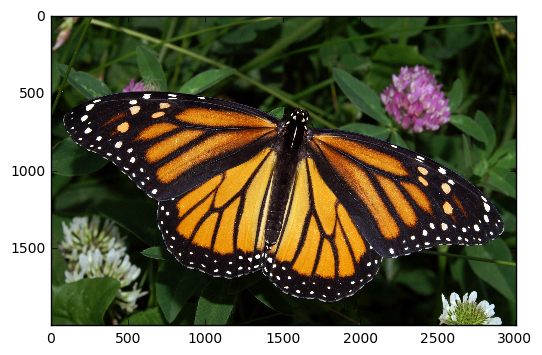

In [31]:
# Read in the image and change color to RGB (from BGR)
image = cv2.imread('data/monarch.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

#### Prepare data for k-means

In [32]:
# Reshape image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image.reshape((-1,3))

# Convert to float type
pixel_vals = np.float32(pixel_vals)

#### Implement k-means clustering

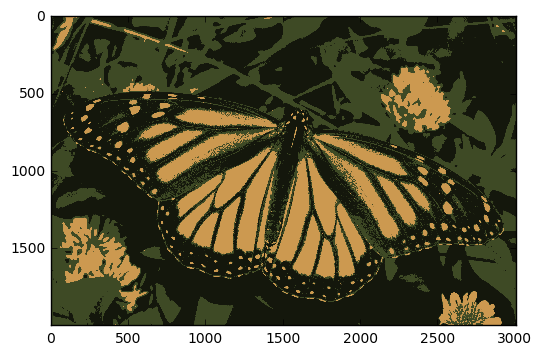

In [33]:
# define stopping criteria
# you can change the number of max iterations for faster convergence!
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.2)

## TODO: Select a value for k
# then perform k-means clustering
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))
labels_reshape = labels.reshape(image.shape[0], image.shape[1])

plt.imshow(segmented_image)

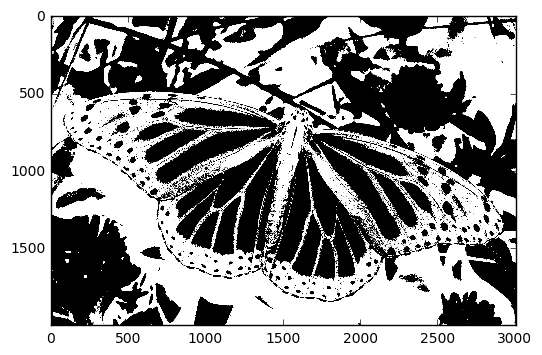

In [34]:
##Visualize one segment, try to find which is the leaves, background, etc!
plt.imshow(labels_reshape==0, cmap='gray')

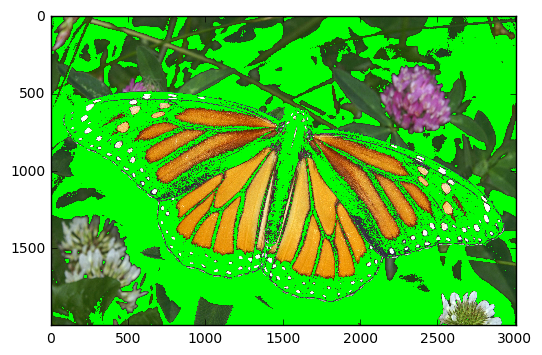

In [35]:
# mask an image segment by cluster

cluster = 0 # the first cluster

masked_image = np.copy(image)
# turn the mask green!
masked_image[labels_reshape == cluster] = [0, 255, 0]

plt.imshow(masked_image)